## Notebook Setup and Uploading of Data to S3

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
!pip install -Uq altair torchtext torchdata

In [3]:
import sagemaker

In [4]:
!mkdir -p nn_src
import sys
sys.path.append('nn_src')

In [5]:
!touch nn_src/train_dummy
BUCKET = sagemaker.Session().default_bucket()
s3_data_url = f's3://{BUCKET}/nn/'
!aws s3 sync nn_src {s3_data_url} --exclude '*' --include 'train_dummy'

upload: nn_src/train_dummy to s3://sagemaker-eu-west-1-811243659808/nn/train_dummy


In [6]:
%%writefile nn_src/requirements.txt
torchtext
torchdata

Overwriting nn_src/requirements.txt


In [7]:
%%writefile nn_src/trenc.py

import math

import torch
from torch import nn
import torch.nn.functional as F 
from torch import log

class EncoderLayer(nn.Module):
    def __init__(self,
                 d,
                 num_heads,
                 dropout,
                 ff_dim, 
                 res_connections):

        super().__init__()

        projection_size = d // num_heads

        self.WQ = nn.Parameter(torch.randn(num_heads, d, projection_size)/math.sqrt(d))
        self.WK = nn.Parameter(torch.randn(num_heads, d, projection_size)/math.sqrt(d))
        self.WV = nn.Parameter(torch.randn(num_heads, d, projection_size)/math.sqrt(d))
        self.WO = nn.Parameter(torch.randn(num_heads, projection_size, d)/math.sqrt(d))

        self.attn_norm = nn.LayerNorm(d)
        self.ff_norm   = nn.LayerNorm(d)
        self.dropout   = nn.Dropout(p=dropout)
        self.ff        = nn.Sequential(
            nn.Linear(d, int(ff_dim*d)), 
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(int(ff_dim*d), d)
        )

        self.res_connections = res_connections
        # Why just one ReLU/GELU, one dropout? Attention is all you need: 4.3, 5.4. 
        
    def forward(self, input):

        X, prv_attention_values = input

        # b batch
        # t step
        # d dimension
        # p projected dimension
        # h head
        
        normalized_X = self.attn_norm(X) # Pre-Norm

        # Creating keys, queries and values from the normalized values, while
        # at the same time down projecting from d dimensions to p dimensions
        keys    = torch.einsum('btd,hdp->bthp', normalized_X, self.WK)
        queries = torch.einsum('btd,hdp->bthp', normalized_X, self.WQ)
        values  = torch.einsum('btd,hdp->bthp', normalized_X, self.WV)

        # Attention values are per position, not per dimension etc.
        dot = torch.einsum('bkhp,bqhp->bhqk', queries, keys)
        scaled_dot = dot / math.sqrt(values.size()[-1])
        attention_values = torch.softmax(scaled_dot, -1)

        assert torch.allclose(attention_values[0, 0, 0].sum(), torch.tensor(1.))

        new_values = torch.einsum('bkhp,bhqk->bqhp', values, attention_values)
        b, t, h, p = new_values.size()

        # Consolidate the invidual head outputs by concenating them
        # and then up projecting from p to d dimensions.
        seq_summary = torch.einsum('bthp,hpd->btd', new_values, self.WO)
        
        # Alternatively: 
        # Concat outputs of the individual heads
        # Using no learnable parameters
        # seq_summary = new_values.view(b, t, -1)

        assert seq_summary.size()[-1] == h*p == X.size()[-1]

        # Residual Connection and Pre-Norm
        if self.res_connections:
            pre_ff = X + self.ff_norm(seq_summary) 
        else:
            pre_ff = self.ff_norm(seq_summary) 

        prv_attention_values.append(attention_values)

        post_ff = self.ff(self.dropout(pre_ff))
        if self.res_connections:
            return post_ff + pre_ff, prv_attention_values
        else:
            return post_ff, prv_attention_values


class TrEnc(nn.Module):
    def __init__(self, 
                 num_classes, 
                 vocab_size, 
                 layers,
                 d,
                 heads,
                 dropout,
                 use_pos_enc,
                 use_cls_token,
                 clf_scale,
                 ff_dim, 
                 **kwargs):
        super().__init__()
        
        print(f'superfluous model parameters not used: {kwargs}')

        res_connections=True
        pos_encoding = 'sin' if use_pos_enc else None
        
        embed_size = d*heads 
        self.pooling  = 'cls' if use_cls_token else 'mean'
        
        self.res_connections = res_connections == True
  
        self.embeddings = nn.Embedding(vocab_size, embed_size, padding_idx=1)
        self.encoder_layers = \
            nn.Sequential(
                *[EncoderLayer(embed_size, heads, dropout, ff_dim, res_connections) for _ in range(layers)],)

        # Empricially it was a toss-up if the additional LN helped or not
        # It is part of the Pre-LN Transformer though
                #nn.LayerNorm(embed_size))
        
        # REVIEW: Just have one matrix for all three weight matrices?
        # REVIEW: Maybe do not project the values, but q and k only
        
        self.dropout     = nn.Dropout(dropout)
        
        if clf_scale:
            intermediate_dim = int(embed_size*clf_scale)
            self.clf = nn.Sequential(
                nn.Linear(embed_size, intermediate_dim, bias=False),
                nn.LayerNorm(intermediate_dim),
                nn.Tanh(),
                nn.Dropout(dropout/2),
                nn.Linear(intermediate_dim, num_classes)
            )
        else:
            self.clf = nn.Linear(embed_size, num_classes)
            
        self.pos_encoder = PositionalEncoding(embed_size, dropout) if use_pos_enc else None

    def extra_repr(self):
        return f'residual_connection={self.res_connections}, pooling={self.pooling}'

    def forward(self, X, output_attentions=False):
        # TODO: Unclear how helpful dropout on embeddings is here. Same p? 
        emb = self.dropout(self.embeddings(X))

        if self.pos_encoder:
            emb = self.pos_encoder(emb) 

        z, attention_values = self.encoder_layers((emb, []))
        
        if self.pooling == 'cls':
            logits = self.clf(self.dropout(z[:, 0]))
        elif self.pooling == 'mean':
            logits = self.clf(self.dropout(z.mean(1)))
        else:
            raise ValueError('Only mean and cls are valid valued for pooling.')

        if output_attentions:
            # return attention as b, l, h, q, k
            return logits, torch.stack(attention_values, 0).transpose(0, 1)
        return logits

# From: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


Overwriting nn_src/trenc.py


In [8]:
%%writefile nn_src/cnn.py

import torch
import torch.nn as nn
import torch.nn.functional as F

                
class CNN(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_classes,
                 d, 
                 kernel_sizes,
                 num_filters,
                 strides,
                 dropout,
                 **kwargs):

        super().__init__()
        print(f'superfluous model parameters not used: {kwargs}')
        assert len(num_filters) == len(kernel_sizes) == len(strides), 'Same number of values for kernel_sizes, num_filters and strides must be specified.'
       
        self.embeddings = nn.Embedding(vocab_size, d, padding_idx=1)
        
        layers = []
        layers.append(Multihead([self._create_conv(
            d, 
            num_filters[i], 
            kernel_sizes[i], 
            dropout, 
            strides[i]
        ) for i in range(len(kernel_sizes))]))
        
        ff_in = sum(num_filters)
        
        self.nn = nn.Sequential(
            *layers,
            nn.BatchNorm1d(ff_in),
            MaxOverTimePooling(),
            nn.Linear(ff_in, num_classes))

    def forward(self, X):
        emb = self.embeddings(X).transpose(2, 1)
        
        return self.nn(emb)

    def _create_conv(self,
                     in_channels,
                     out_channels,
                     kernel_size,
                     dropout,
                     stride):
        
        padding = int((kernel_size-1)//2)
        
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout))

class MaxOverTimePooling(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.max(x, -1)[0]

class Cat(nn.Module):
    def __init__(self, dim=0):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return torch.cat(x, dim=self.dim)
    def extra_repr(self):
        return str(f'dim={self.dim}')

class Multihead(nn.Module):
    def __init__(self, heads, dim=1):
        super().__init__()
        self.heads = nn.ModuleList(heads)
        self.cat = Cat(dim)

    def forward(self, x):
        outputs = [head(x) for head in self.heads]
        return self.cat(outputs)


Overwriting nn_src/cnn.py


In [9]:
%%writefile nn_src/util.py

from ast import literal_eval

def count_parameters(m, verbose=True):
    total_count = 0
    learnable_count = 0
    if verbose:
        print('Parameters (name, tunable, count):')
    for n, p in m.named_parameters():
        count = p.data.numel() 
        if verbose:
            print(f' {n:60s} {p.requires_grad:5b} {count:>9d}')
        total_count += count
        if p.requires_grad:
            learnable_count += count
    if verbose:
        print(f'Total parameters: {total_count}, thereof learnable: {learnable_count}')
    return total_count, learnable_count

def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')
        
def str2ints(v):
    assert isinstance(v, str)
    
    obj = literal_eval(v)
    assert isinstance(obj, list), f'parsed value needs to be a list, not {type(obj)}'
    for elem in obj:
        assert isinstance(elem, int)
    
    return obj

Overwriting nn_src/util.py


In [10]:
%%writefile nn_src/train.py

import sys
import argparse
import random
import math
from time import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchdata.datapipes as dp

from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from util import str2bool, str2ints, count_parameters
from trenc import TrEnc
from cnn import CNN

def parse_args(arg_values_to_parse):
    parser = argparse.ArgumentParser()

    parser.add_argument('--epochs', type=int, default=1) 
    parser.add_argument('--early-stopping-patience', type=int, default=0)
    parser.add_argument('--batch-size', dest='bs', type=int, default=32) 
    parser.add_argument('--lr', type=float, default=5e-5) 
    
    parser.add_argument('--model', type=str, default='TrEnc')
    parser.add_argument('--vocab-size',    type=int, default=10_000) 
    parser.add_argument('--max-input-len', type=int, default=64) 
    
    # model
    parser.add_argument('--dropout', dest='m_dropout',type=float, default=0.2) 
    parser.add_argument('--layers',  dest='m_layers',type=int, default=1) 
  
    # dim is used for embedings. If a TrEnc, then embed_size = dim*heads
    parser.add_argument('--dim', dest='m_d',     type=int, default=64) 
    
    # model trenc
    parser.add_argument('--heads',   dest='m_heads', type=int, default=8) 
    parser.add_argument('--ff-dim',  dest='m_ff_dim',type=float, default=4.) 
    parser.add_argument('--use-cls-token', dest='m_use_cls_token', type=str2bool, default=True)
    parser.add_argument('--use-pos-enc',   dest='m_use_pos_enc',   type=str2bool, default=False)
    parser.add_argument('--clf-scale',     dest='m_clf_scale', type=float, default=1.0)
    
    # model cnn
    parser.add_argument('--kernel-sizes', dest='m_kernel_sizes', type=str2ints, default='[1, 3]')
    parser.add_argument('--num-filters',  dest='m_num_filters',  type=str2ints, default='[48, 48]')
    parser.add_argument('--strides',      dest='m_strides',      type=str2ints, default='[1, 1]')
    
    parser.add_argument('--dummy', dest='_ignore',type=float, default=0.) 
    
    
    # FIXME: Should I add a separate pooler?
        
    return parser.parse_args(arg_values_to_parse)

def main(*arg_values_to_parse):
    
    args = parse_args([str(la) for la in arg_values_to_parse])
    print('Arguments:', args)
  
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    ### Data
    train_dp, valid_dp = IMDB(root='imdb_data', split=('train', 'test'))
    
    ### Built vocab and tokenizer
    tokenizer = get_tokenizer('basic_english')

    vocab = build_vocab_from_iterator(
        map(tokenizer, (text for (_, text) in train_dp)), specials=['<UNK>', '<PAD>'], 
        max_tokens=args.vocab_size
    )
    vocab.set_default_index(vocab['<UNK>'])
    
    print(f'Vocabulary built with {len(vocab.get_itos())} tokens.')
    
    ### Data Loader
    def vectorize(y, x):
        y = 0 if y == 'neg' else 1
        return (y, vocab(tokenizer(x)))
    
    def collate(data):
        batch_len = min(args.max_input_len, max([len(x) for (_, x) in data]))
        
        padding = [1] * batch_len # <PAD> has index 1
        y, x = zip(*[(y, (x+padding)[:batch_len]) for (y, x) in data])
 
        return torch.LongTensor(y).to(dev), torch.LongTensor(x).to(dev)
    
    train_dl = DataLoader(
        dataset=[vectorize(y, x) for (y, x) in train_dp], 
        batch_size=args.bs, 
        shuffle=True,
        drop_last=True,
        collate_fn=collate)
    del train_dp
    
    valid_ds = [vectorize(y, x) for (y, x) in valid_dp]
    random.shuffle(valid_ds)
    valid_dl = DataLoader(
        dataset=valid_ds[:7500], 
                batch_size=args.bs*2,
                collate_fn=collate)  
    del valid_dp
    del valid_ds
    
    ### Model
    # Instantiate model and pass all command line args that start with m_
    model_args = {
        'num_classes': 2, # neg, pos 
        'vocab_size': len(vocab.get_itos()),
        **{k[2:]: v for k, v in vars(args).items() if k.startswith('m_')}
    }
    
    
    model_cls = None
    if args.model == 'TrEnc':
        model_cls = TrEnc
    elif args.model == 'CNN':
        model_cls = CNN
    
    model = model_cls(**model_args).to(dev)

    print('Model instantiated:', model)

    # prints 'learnable: ddd' to stdout
    count_parameters(model)[1]
    
    ### Train Loop
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
    criterion = nn.CrossEntropyLoss(reduction='sum')
        
    scaler = torch.cuda.amp.GradScaler()
    
    best_valid_loss = math.inf
    best_epoch = None
    
    #FIXME: documentation.
    best_result_store = None 
    
    for epoch in range(args.epochs):
        model.train()
        train_loss_epoch = 0.
        train_count_epoch = 0
        started = time()
    
        for i, (Yb, Xb) in enumerate(train_dl): 
            
            with torch.cuda.amp.autocast():
                logits = model(Xb)
            
                loss = criterion(logits, Yb)
            
            scaler.scale(loss).backward()
            
            scaler.step(optimizer)
            scaler.update()
            
            train_loss_epoch  += loss.item() 
            train_count_epoch += len(Yb)
            optimizer.zero_grad()

            if i % 50 == 0: 
                print(f'i: {i:4d}: batch_train_loss: {loss/len(Yb):6.4f}')
                
        model.eval()
        with torch.no_grad():
            valid_count_epoch = 0
            matched_epoch = 0
            valid_loss_epoch = 0.
            
            for i, (Yb, Xb) in enumerate(valid_dl):
                with torch.cuda.amp.autocast():
                    logits = model(Xb)
                    valid_loss_epoch += criterion(logits, Yb).item()
                    
                    predictions = logits.argmax(-1)
                    matched_epoch += (predictions == Yb).sum().item()
                    valid_count_epoch += len(Yb)

            acc = matched_epoch/valid_count_epoch
        
        log_message = f'ep: {epoch} train_loss: {train_loss_epoch/train_count_epoch:6.5f} valid_loss: {valid_loss_epoch/valid_count_epoch:6.5f} valid_acc: {acc:5.4f} took: {time()-started:5.3f}s'
        print(log_message)
        
        if valid_loss_epoch < best_valid_loss:
            best_valid_loss = valid_loss_epoch
            best_result_store = log_message
            best_epoch = epoch
            
            print(f'epoch {epoch} was the best epoch so far.')
            
        # early stopping 
        print(f'best epoch {best_epoch}, epoch {epoch}, diff {(epoch-best_epoch)}')
        if best_epoch and epoch >= args.early_stopping_patience-1 and (epoch-best_epoch) >= args.early_stopping_patience:
            print(f'No progress for {args.early_stopping_patience} epochs. Stopping early.')
            break
                
    print('End of training.')
    print('Re-reporting best loss epoch:')
    print(best_result_store)

if __name__ == '__main__':
    print('main', sys.argv)
    main(*sys.argv[1:])    

Overwriting nn_src/train.py


!0!2.0
!1!1.5
!2!1.3
!3!1.3 (last improvement)
!4!1.4
!5!1.5
!6!1.6



In [ ]:
# Uncomment the following line when you want to test your script locally (validate arg parsing for example)
#!python nn_src/train.py --epochs 20 --kernel-sizes '[1, 3]' --model 'CNN' --dim 32 --strides '[1, 1]' --num-filters '[12, 12]'

In [ ]:
# Uncomment below to directly call the implementation. 
# To check if you have typos or mismatched dimensions, before you submit it to a container training.
# But also for example use PDB.
from nn_src.train import main as fit
fit('--epochs', 20,
    '--vocab-size', 1_000,
    '--batch-size', 128,
    '--lr', 1e-1, 
    '--layers', 1,
    '--dim', 8,
    '--ff-dim', 4,
    '--heads', 4,
    '--max-input-len', 64,
    '--early-stopping-patience', 2,
    '--clf-scale', 0.,
    # '--model', 'CNN',
    # '--dim', 32,
    # '--strides', [1, 1],
    # '--num-filters', [12, 12],
    # '--kernel-sizes', [1, 3]
)

In [ ]:
xxx

In [12]:
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

In [13]:
metric_definitions = [
    {'Name': 'Epoch',               'Regex': r'ep:\s+(-?[0-9\.]+)'},
    {'Name': 'Valid:Acc',           'Regex': r'valid_acc:\s+(-?[0-9\.]+)'},
    {'Name': 'Train:Loss',          'Regex': r'train_loss:\s+(-?[0-9\.]+)'},
    {'Name': 'Valid:Loss',          'Regex': r'valid_loss:\s+(-?[0-9\.]+)'}, 
    {'Name': 'LearnableParameters', 'Regex': r'learnable:\s+(-?[0-9\.]+)'} 
]                                 

In [14]:
estimator = PyTorch(
    'train.py',
    source_dir='nn_src',
    role=get_execution_role(),
    instance_type= 'ml.g4dn.xlarge',
    instance_count=1,
    framework_version='1.10',
    py_version='py38',
    metric_definitions=metric_definitions,
    base_job_name='nn',

    use_spot_instances= True,
    max_run=  60 * 60 * 24,
    max_wait= 60 * 60 * 24,

    keep_alive_period_in_seconds= 120,

    hyperparameters = {'early-stopping-patience': 5, 
                       'epochs': 25,
                       'batch-size': 128,
                       'lr': 2e-4,
                       'vocab-size': 4_000,
                       'heads': 12,
                       'dim': 32, 
                       'max-input-len': 256,
                       'layers': 1,
                       'dropout': 0.25, 
                       'use-cls-token': True,
                       'use-pos-enc': True,
                       'clf-scale': 1.,
                       'ff-dim': 4.,
                       
                       # 'model': 'CNN', # 'TrEnc', 'CNN'
                       # 'dim': 128,
                       # 'strides': '\'[1, 1]\'',
                       # 'num-filters': '\'[12, 12]\'',
                       # 'kernel-sizes': '\'[1, 3]\'',
                      }
    ) 

In [ ]:
estimator.fit({'train': s3_data_url+'train_dummy'}, wait=False)

### Automatic Model Tuning Jobs
#### Random Sweep to check the lay of the land

In [15]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner
# next: vocab-size

hpt_ranges = {
    'dummy': ContinuousParameter(0, 1, 'Linear'), 
    #'vocab-size': IntegerParameter(1_00, 10_000, 'Linear'),
    #'lr': ContinuousParameter(1e-6, 1e-2), 
    #'max-input-len': IntegerParameter(32, 1024, "Linear"),
    #'dropout': ContinuousParameter(0.2, 0.6),
    #'heads': IntegerParameter(4, 16),
    #'dim': IntegerParameter(8, 128),
    #'ff-dim': ContinuousParameter(0.1, 10, 'Linear'),
    #'layers': IntegerParameter(1, 12),
    'layers': CategoricalParameter([1, 4, 8]),
    #'model': CategoricalParameter(['SentimentNN', 'TrEnc']),
    #'use-pos-enc': CategoricalParameter([True, False]),
    #'use-cls-token': CategoricalParameter([True, False])
    'clf-scale': CategoricalParameter([0.0, 1.0])
}

tuner_parameters = {'estimator': estimator,
                    'base_tuning_job_name': 'clf-scale-la',
                    'metric_definitions': metric_definitions,
                    
                    'objective_metric_name': 'Valid:Acc',
                    'objective_type': 'Maximize',
                    'hyperparameter_ranges': hpt_ranges,
                    'strategy': 'Random',
                    'early_stopping_type': 'Off',
                    
                    'max_jobs': 75,           # Was: 20 
                    'max_parallel_jobs': 3}   # Was: 20

In [ ]:
tuner = HyperparameterTuner(**tuner_parameters)
tuner.fit({'train': s3_data_url+'train_dummy'}, wait=False)
tuner_name = tuner.describe()["HyperParameterTuningJobName"]
print(f'tuning job submitted: {tuner_name}.')

In [ ]:
# ClientError: An error occurred (ValidationException) when calling the CreateHyperParameterTuningJob operation: You don't have enough combinations of hyperparameter ranges. The total number of hyperparameter combinations for the provided ranges [6.0] must be equal or greater than the value of MaxNumberOfJobs, [75]. Provide additional ranges.
# which means I cannot use warm start, nor can I use Bayesian

In [16]:
# trenc

model      = 'model-221020-1931'
layers     = 'layers-221020-1931'
md_lr      = ['model-lr-tr-221020-2000', 'model-lr-nn-221020-2001', 'model-lr-nn-221021-1022']
pos_enc    = 'pos-enc-221020-2003'
pos_enc_lr = ['pe-t-lr-221020-2140', 'pe-f-lr-221020-2141']
ff_dim     = ['ff-dim-221021-1242']
dropout    = 'dropout-221021-1541'
input_len  = 'input-len-221021-1542'
vocab_size = 'input-len-221021-1631'
beefy_c_l  = ['beefy-layers-221021-2041', 'beefy-layers-221022-1013'] # and multi layers
beefy_c_l  = 'beefy-layers-221022-1013'
clf_scl_la = 'clf-scale-la-221022-1317' # and multi layers

# cnn
sweep      = 'cnn-sweep-221021-1921'

Tuning job clf-scale-la-221022-1317  status: InProgress

Number of training jobs with valid objective: 15
Lowest: 0.7968999743461609 Highest 0.8468999862670898


,clf-scale,dummy,layers,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,Valid:Acc
10,0.0,0.655625,4,clf-scale-la-221022-1317-008-acfa2a29,Completed,2022-10-22 14:21:21+02:00,2022-10-22 14:52:00+02:00,1839.0,clf-scale-la-221022-1317,0.8469
13,0.0,0.790381,8,clf-scale-la-221022-1317-005-8b671296,Completed,2022-10-22 13:32:10+02:00,2022-10-22 14:36:43+02:00,3873.0,clf-scale-la-221022-1317,0.8409
11,0.0,0.973232,8,clf-scale-la-221022-1317-007-e5f6df02,Completed,2022-10-22 13:46:31+02:00,2022-10-22 14:47:02+02:00,3631.0,clf-scale-la-221022-1317,0.8383
9,0.0,0.201456,4,clf-scale-la-221022-1317-009-b36ba9c5,Completed,2022-10-22 14:38:59+02:00,2022-10-22 15:07:20+02:00,1701.0,clf-scale-la-221022-1317,0.8368
12,0.0,0.312724,4,clf-scale-la-221022-1317-006-a2e793fd,Completed,2022-10-22 13:46:23+02:00,2022-10-22 14:15:52+02:00,1769.0,clf-scale-la-221022-1317,0.8325
5,0.0,0.808803,1,clf-scale-la-221022-1317-013-5bd7febc,Completed,2022-10-22 15:08:54+02:00,2022-10-22 15:23:04+02:00,850.0,clf-scale-la-221022-1317,0.8239
7,1.0,0.172003,4,clf-scale-la-221022-1317-011-e9074775,Completed,2022-10-22 14:54:31+02:00,2022-10-22 15:18:25+02:00,1434.0,clf-scale-la-221022-1317,0.8113
16,1.0,0.156893,1,clf-scale-la-221022-1317-002-586a2874,Completed,2022-10-22 13:19:19+02:00,2022-10-22 13:29:53+02:00,634.0,clf-scale-la-221022-1317,0.8089
8,0.0,0.693244,1,clf-scale-la-221022-1317-010-e8ad6add,Completed,2022-10-22 14:50:27+02:00,2022-10-22 15:03:17+02:00,770.0,clf-scale-la-221022-1317,0.8088
15,1.0,0.437686,4,clf-scale-la-221022-1317-003-58ae97dc,Completed,2022-10-22 13:19:21+02:00,2022-10-22 13:42:38+02:00,1397.0,clf-scale-la-221022-1317,0.8076


CPU times: user 2.04 s, sys: 173 ms, total: 2.22 s
Wall time: 10.7 s


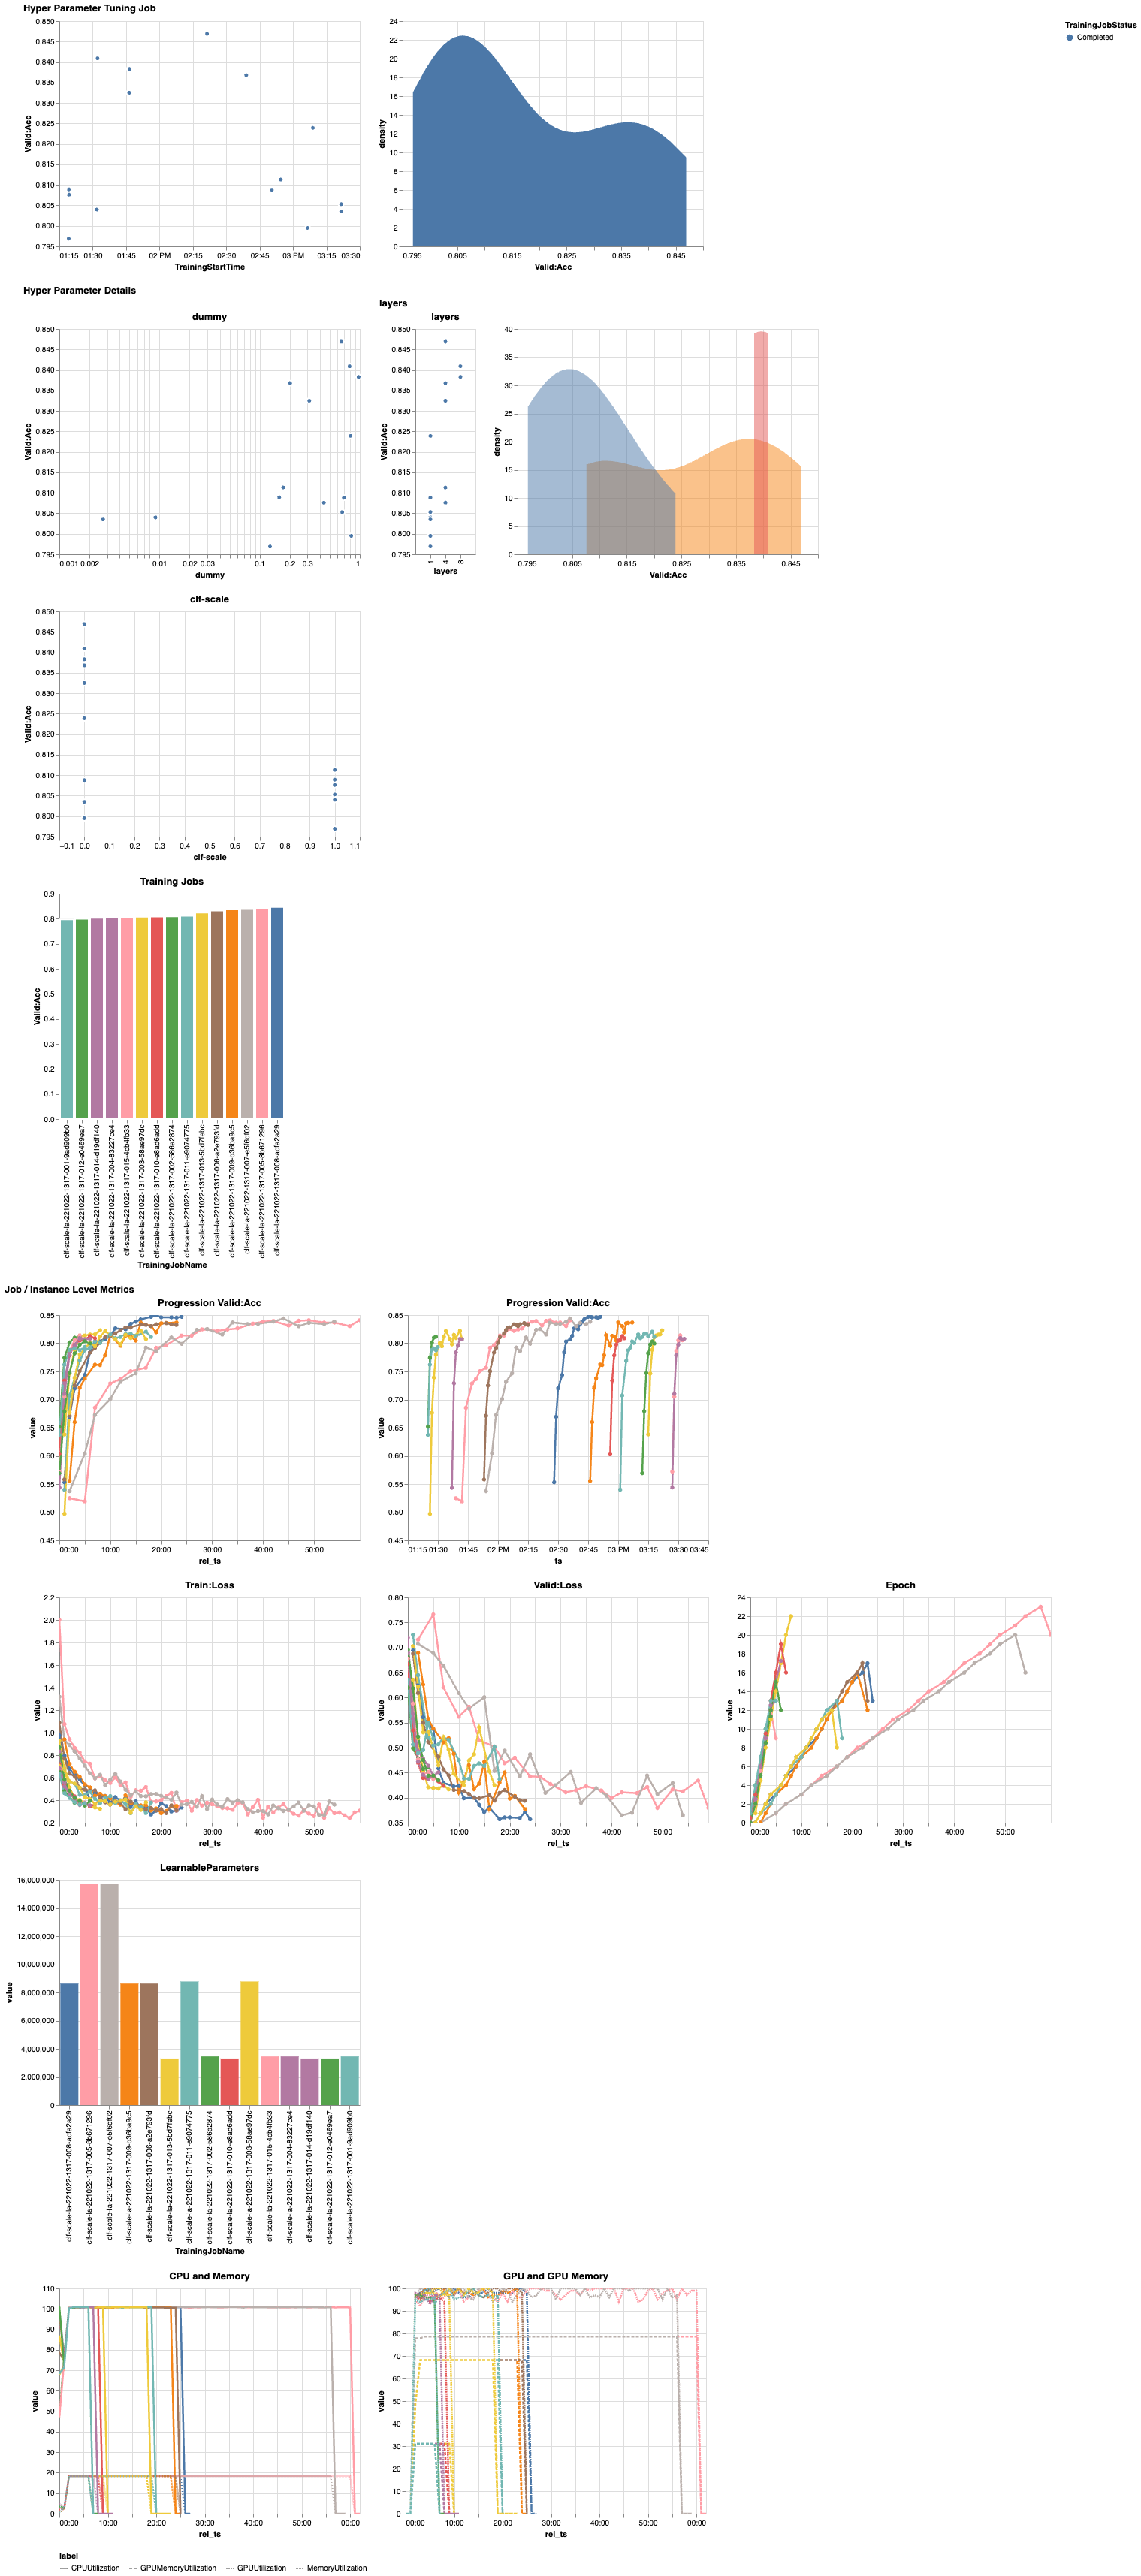

In [17]:
%%time
from reporting_util import analyze_hpo_job
chart, trials_df, full_df = analyze_hpo_job(
    clf_scl_la, 
    return_dfs=True,
    job_metrics=[
        'Train:Loss',
        'Valid:Loss',
        'Epoch',
        'LearnableParameters'
    ]
)
chart 

In [ ]:
# sample 256 tokens from t, m, e